# Compare diferent prediction results
## Imports

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from LogisticRegresion import ajustLogisticRegression
from Matrix import convert_matrix
from NMF import generateNMF
from sklearn.model_selection import train_test_split
import psycopg2

import numpy
from psycopg2.extensions import register_adapter, AsIs

# Get the data

In [2]:
table = convert_matrix(sumvals=False)
table

(590, 58840)


,,aaaaaaa,aaaaaaaa,aaaaaaab,aaaaaaac,aaaaaaad,aaaaaaae,aaaaaaaf,aaaaaaag,aaaaaaah,aaaaaaai,...,kkb,kke,lab,lbb,lbbb,lbbc,lcc,leb,lib,libb
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
20,0,1,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,1,1,1,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
151,1,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
177,1,1,1,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
214,1,1,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
263,1,1,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
279,1,1,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
283,1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
368,1,1,1,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Dividir los datos entre datos de entrenamiento y datos de prueba

In [3]:
subjects = table.index.levels[0].tolist()
survived = table.index.labels[1].tolist()
patients = table.values
patients_train, patients_test,subject_train, subject_test,survived_train, survived_test = train_test_split(patients,subjects, 
                                                                               survived,test_size=0.2, random_state=42)

## Obtener los score de SOFA y SAPS

In [4]:
def select_score(subjects, table='saps', dbname="mimic"):
    """Selects the saps of the subjects.
    """
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = '''SELECT a.'''+table+''',a.icustay_id
    FROM '''+table+''' a
    INNER JOIN (select subject_id,max(icustay_id) as icustay_id from '''+table+''' group by subject_id) b
    ON a.subject_id = b.subject_id and a.icustay_id = b.icustay_id
    WHERE a.subject_id in %s '''
    cur.execute(select_stament,(subjects,))
    select = []
    for row in cur:
        select.append((row[0]))
    cur.close()
    conn.close()
    return select

In [5]:
def addapt_numpy_float64(numpy_float64):
  return AsIs(numpy_float64)
register_adapter(numpy.float64, addapt_numpy_float64)
def addapt_numpy_int64(numpy_int64):
  return AsIs(numpy_int64)
register_adapter(numpy.int64, addapt_numpy_int64)

In [6]:
saps = select_score(tuple(subject_test),table='saps')
sofa = select_score(tuple(subject_test),table='sofa')

In [7]:
from sklearn.metrics import roc_auc_score
roc_auc_saps = roc_auc_score(survived_test, saps)
roc_auc_sofa = roc_auc_score(survived_test, sofa)

## Obtener el modelo de la regresion logistica

In [8]:
table = convert_matrix(with_pearson=100,len_words=(6,6))
subjects = table.index.levels[0].tolist()
survived = table.index.labels[1].tolist()
patients = table.values
p_train, p_test,surv_train, surv_test = train_test_split(patients,survived,test_size=0.2, random_state=42)
logisticReg = ajustLogisticRegression(p_train,surv_train,p_test,surv_test)
regresion = logisticReg['model'].predict_proba(p_test)[:,1]

(532, 100)


## Obtener el modelo de NMF

In [9]:
components = [{'n_components':11,'type':'Menor error'}
              ,{'n_components':36,'type':'Mejor Coeficiente de pearson'}
              ,{'n_components':34,'type':'Maximo AUC'},
#              {'n_components':50,'type':'Maximo Exactitud de la regresion logistica'}
#              ,{'n_components':100,'type':'Maximo AUC'},
              {'n_components':150,'type':'Maximo Exactitud de la regresion logistica'}
#              ,{'n_components':200,'type':'Maximo AUC'},
#              {'n_components':250,'type':'Maximo Exactitud de la regresion logistica'}
             ]
nmfresults = []
for component in {12,19,56,5}:
    n_components = component
    nmfGen = generateNMF(patients, survived, n_components=n_components)
    nmfGen['name']='NMF '+str(n_components)
    nmfresults.append(nmfGen)

## Imprimir los resultados

In [10]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [11]:
def roc_curveplot(name,y_true,y_score,logit_roc_auc):
    fpr, tpr, thresholds = roc_curve(y_true,y_score)
    plt.plot(fpr,tpr,label=str(name)+' AUC =%.3f' % logit_roc_auc)

NMF 56 0.53934571176
NMF 19 0.522988505747
NMF 12 0.522546419098
NMF 5 0.513262599469


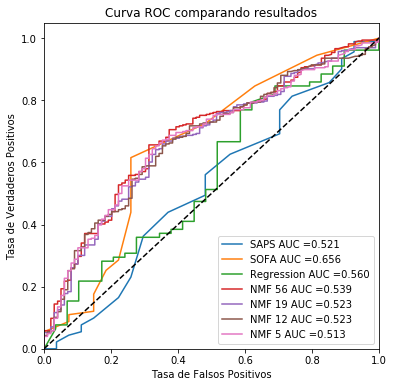

In [12]:
fig_size = [6, 6]
plt.rcParams["figure.figsize"] = fig_size
plt.figure()
roc_curveplot('SAPS',survived_test,saps,roc_auc_saps)
roc_curveplot('SOFA',survived_test,sofa,roc_auc_sofa)
roc_curveplot('Regression',surv_test,regresion,logisticReg['roc_auc'])
for nmfresult in nmfresults:
    print(nmfresult['name'],nmfresult['roc_auc'])
    roc_curveplot(nmfresult['name'],nmfresult['survived_test'],nmfresult['predict_poba'],nmfresult['roc_auc'])
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC comparando resultados')
plt.legend(loc="lower right")
plt.show()